In [1]:
import pandas as pd

import numpy as np

import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 15, 11

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, seasonal_decompose
from sklearn.metrics import mean_squared_error

from statsmodels.tools.eval_measures import mse

import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'data\final_data_predict.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [3]:
df

TMIN       TMAX  ELECTRIC_PROD  BEER_PROD
DATE                                                      
1985-01-01  38.193548  50.516129        72.5052       93.2
1985-02-01  37.821429  50.535714        70.6720       96.0
1985-03-01  41.612903  55.967742        62.4502       95.2
1985-04-01  42.066667  57.066667        57.4714       77.1
1985-05-01  46.870968  62.516129        55.3151       70.9
...               ...        ...            ...        ...
2017-09-01  56.466667  70.433333        98.6154      145.1
2017-10-01  45.741935  57.612903        93.6137      183.7
2017-11-01  42.066667  53.700000        97.3359      210.5
2017-12-01  34.774194  44.645161       114.7212      203.3
2018-01-01  39.354839  49.290323       129.4048      153.3

[397 rows x 4 columns]

In [4]:
data = []
for i in df.columns:
    data.append(go.Scatter(
            x = df.index, y = df[i], name=i
            ))
    
data = data
layout = {'title': 'Data'}

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [5]:
def moving_avarage(df, n):
    df_av = df.rolling(window=n).mean()#.dropna()
    #df_av = df_av.fillna(df_av.median())
    
    return df_av

In [6]:
moving_avarage(df, 4)

TMIN       TMAX  ELECTRIC_PROD  BEER_PROD
DATE                                                      
1985-01-01        NaN        NaN            NaN        NaN
1985-02-01        NaN        NaN            NaN        NaN
1985-03-01        NaN        NaN            NaN        NaN
1985-04-01  39.923637  53.521563      65.774700     90.375
1985-05-01  42.092992  56.521563      61.477175     84.800
...               ...        ...            ...        ...
2017-09-01  57.283602  75.558602     105.463400    146.600
2017-10-01  54.794086  71.503495     103.328525    157.625
2017-11-01  51.036559  65.186559      99.624050    173.200
2017-12-01  44.762366  56.597849     101.071550    185.650
2018-01-01  40.484409  51.312097     108.768900    187.700

[397 rows x 4 columns]

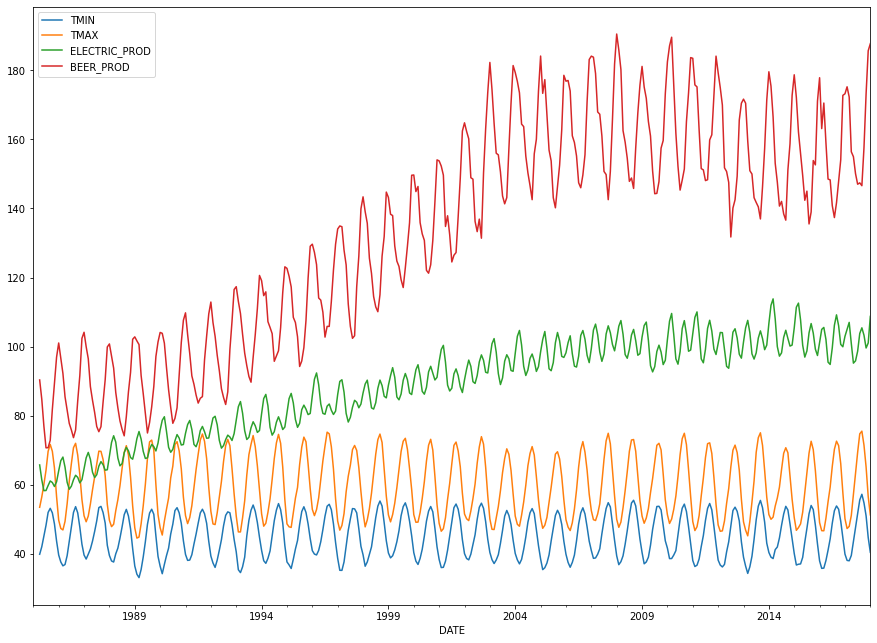

In [7]:
moving_avarage(df, 4).plot();

In [8]:
def exp_smoothing(df, alpha):
    df_ex = df.ewm(alpha=alpha, adjust=True).mean().dropna()

    return df_ex

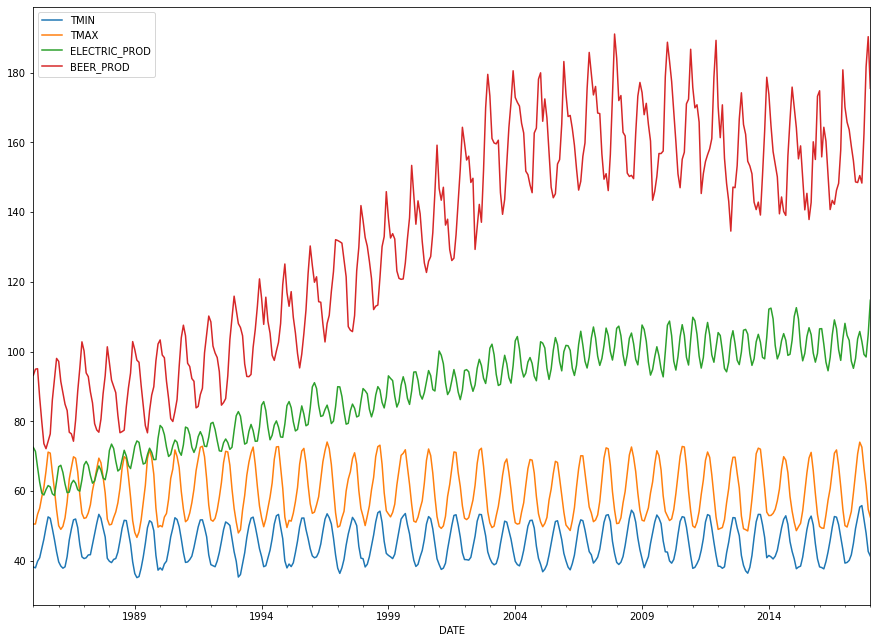

In [9]:
df = exp_smoothing(df, 0.4)
df.plot();

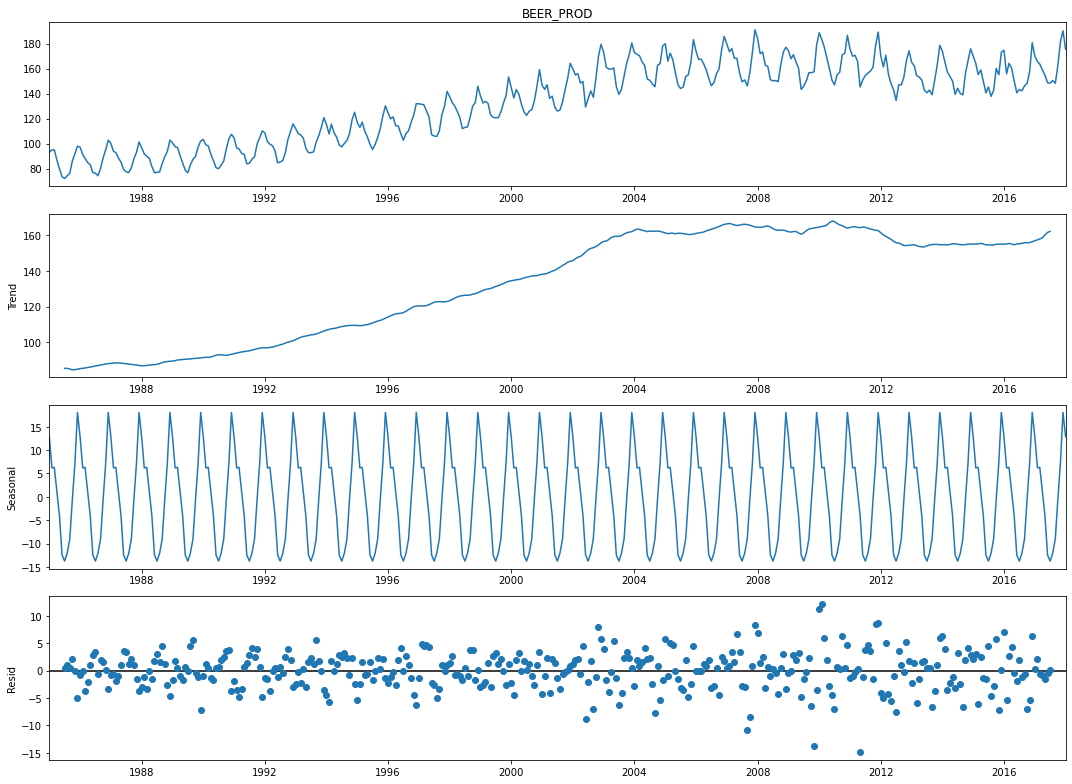

In [10]:
decomposition = seasonal_decompose(df['BEER_PROD'], model='add')
fig = decomposition.plot()

In [11]:
df_train, df_test = df.iloc[:round(len(df)*0.9), :], df.iloc[round(len(df)*0.9): , :]

In [12]:
df_train

TMIN       TMAX  ELECTRIC_PROD   BEER_PROD
DATE                                                       
1985-01-01  38.193548  50.516129      72.505200   93.200000
1985-02-01  37.960974  50.528370      71.359450   94.950000
1985-03-01  39.824203  53.303560      66.813914   95.077551
1985-04-01  40.854747  55.032929      62.520479   86.815809
1985-05-01  43.464142  58.278592      59.395315   79.912700
...               ...        ...            ...         ...
2014-05-01  42.981864  57.183451      97.900084  150.123645
2014-06-01  46.189118  60.563404      99.491251  139.514187
2014-07-01  49.390890  66.286430     103.114630  144.348512
2014-08-01  51.853889  69.849277     105.146378  140.169107
2014-09-01  52.885667  68.842900     103.254707  139.061464

[357 rows x 4 columns]

In [40]:
def hyperselect():
    final_hyperparams = []
    for f in df.columns:    
        thresh_params = np.arange(0, 1, 0.05)
        mse_arr = []
        param_arr = []

        for i in thresh_params:
            for j in thresh_params:

                model = Holt(df_train[f]).fit(smoothing_level= i, smoothing_trend= j)
                pred = model.predict(start = df_test.index[0], end = df_test.index[-1])

                mse_arr.append(np.sqrt(mse(pred, df_test[f], axis=0)))
                param_arr.append([i, j])


        final_hyperparams.append(param_arr[mse_arr.index(np.amin(mse_arr))])

    hyperparams_dict = dict(zip(df.columns, np.round(final_hyperparams, 2)))
    
    return hyperparams_dict

In [41]:
%%time
hyperparams = hyperselect()

Wall time: 1min 15s


In [42]:
hyperparams

{'TMIN': array([0.05, 0.05]),
 'TMAX': array([0.05, 0.05]),
 'ELECTRIC_PROD': array([0.55, 0.25]),
 'BEER_PROD': array([0.05, 0.4 ])}

2014-10-01    153.145724
2014-11-01    153.348131
2014-12-01    153.550538
2015-01-01    153.752946
2015-02-01    153.955353
2015-03-01    154.157760
2015-04-01    154.360167
2015-05-01    154.562575
2015-06-01    154.764982
2015-07-01    154.967389
2015-08-01    155.169796
2015-09-01    155.372204
2015-10-01    155.574611
2015-11-01    155.777018
2015-12-01    155.979426
2016-01-01    156.181833
2016-02-01    156.384240
2016-03-01    156.586647
2016-04-01    156.789055
2016-05-01    156.991462
2016-06-01    157.193869
2016-07-01    157.396276
2016-08-01    157.598684
2016-09-01    157.801091
2016-10-01    158.003498
2016-11-01    158.205906
2016-12-01    158.408313
2017-01-01    158.610720
2017-02-01    158.813127
2017-03-01    159.015535
2017-04-01    159.217942
2017-05-01    159.420349
2017-06-01    159.622756
2017-07-01    159.825164
2017-08-01    160.027571
2017-09-01    160.229978
2017-10-01    160.432385
2017-11-01    160.634793
2017-12-01    160.837200
2018-01-01    161.039607


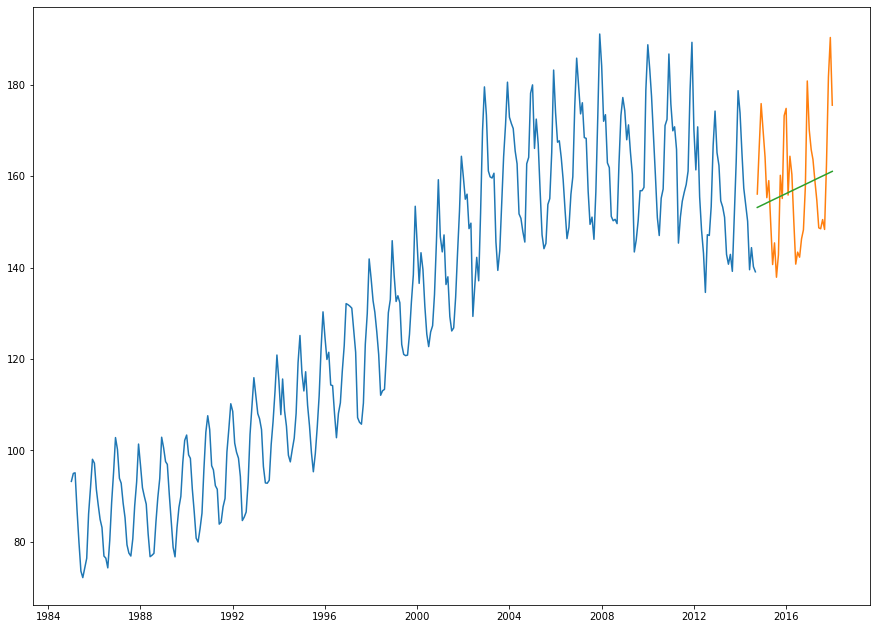

In [16]:
model = Holt(df_train['BEER_PROD']).fit(smoothing_level=0.05, smoothing_trend=0.4)
pred = model.predict(start = df_test.index[0], end = df_test.index[-1])
print(pred)


plt.plot(df_train.index, df_train['BEER_PROD'], label='train')
plt.plot(df_test.index, df_test['BEER_PROD'], label='test')
plt.plot(pred.index, pred, label='predict')
plt.show()

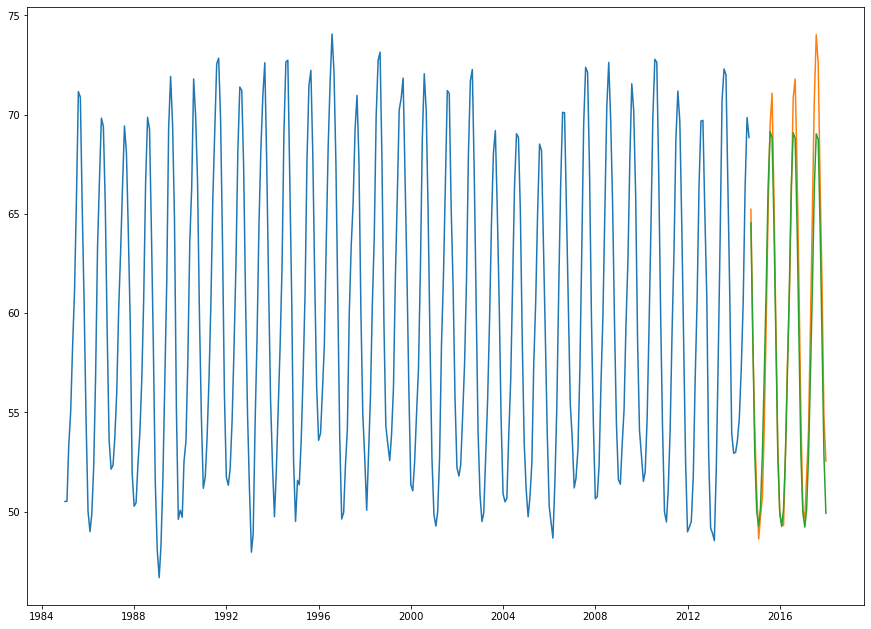

In [17]:
model = ExponentialSmoothing(df_train['TMAX'], seasonal_periods=12, trend='mul', seasonal='add', use_boxcox=True, initialization_method="estimated").fit(optimized=True, use_brute=True)
pred = model.predict(start = df_test.index[0], end = df_test.index[-1])

plt.plot(df_train.index, df_train['TMAX'], label='train')
plt.plot(df_test.index, df_test['TMAX'], label='test')
plt.plot(pred.index, pred, label='predict')
plt.show()

In [92]:
def holt_predict(df_train, df_test, feature_drop2):
    
    hyperparams = {'TMIN': np.array([0.05, 0.05]),
                   'TMAX': np.array([0.05, 0.05]),
                   'ELECTRIC_PROD': np.array([0.55, 0.25]),
                   'BEER_PROD': np.array([0.05, 0.4 ])}
    
    
    model = Holt(df_train[feature_drop2]).fit(smoothing_level=hyperparams[feature_drop2][0], 
                                              smoothing_trend=hyperparams[feature_drop2][1])
    pred = model.predict(start = df_test.index[0], end = df_test.index[-1])
    
    return pred, hyperparams[feature_drop2][0],hyperparams[feature_drop2][1]

        
    
    
    
    

In [93]:
holt_predict(df_train, df_test, 'ELECTRIC_PROD')

(2014-10-01    103.116758
 2014-11-01    103.100959
 2014-12-01    103.085159
 2015-01-01    103.069359
 2015-02-01    103.053560
 2015-03-01    103.037760
 2015-04-01    103.021960
 2015-05-01    103.006161
 2015-06-01    102.990361
 2015-07-01    102.974561
 2015-08-01    102.958762
 2015-09-01    102.942962
 2015-10-01    102.927162
 2015-11-01    102.911363
 2015-12-01    102.895563
 2016-01-01    102.879763
 2016-02-01    102.863964
 2016-03-01    102.848164
 2016-04-01    102.832364
 2016-05-01    102.816564
 2016-06-01    102.800765
 2016-07-01    102.784965
 2016-08-01    102.769165
 2016-09-01    102.753366
 2016-10-01    102.737566
 2016-11-01    102.721766
 2016-12-01    102.705967
 2017-01-01    102.690167
 2017-02-01    102.674367
 2017-03-01    102.658568
 2017-04-01    102.642768
 2017-05-01    102.626968
 2017-06-01    102.611169
 2017-07-01    102.595369
 2017-08-01    102.579569
 2017-09-01    102.563770
 2017-10-01    102.547970
 2017-11-01    102.532170
 2017-12-01 

In [94]:
def holt_winters_predict(df_train, df_test, feature_drop2):
    model = ExponentialSmoothing(df_train[feature_drop2], 
                                 seasonal_periods=12, trend='mul', seasonal='add', 
                                 use_boxcox=True, 
                                 initialization_method="estimated").fit(optimized=True, use_brute=True)

    pred = model.predict(start = df_test.index[0], end = df_test.index[-1])
    
    return pred
    
    
    
    

In [95]:
holt_winters_predict(df_train, df_test, 'ELECTRIC_PROD')

2014-10-01     97.773851
2014-11-01     96.229963
2014-12-01    101.367897
2015-01-01    107.776613
2015-02-01    107.330687
2015-03-01    104.159471
2015-04-01     97.979812
2015-05-01     95.750027
2015-06-01     98.828434
2015-07-01    104.267686
2015-08-01    107.012574
2015-09-01    104.015953
2015-10-01     98.875069
2015-11-01     97.348063
2015-12-01    102.439142
2016-01-01    108.794803
2016-02-01    108.354155
2016-03-01    105.211235
2016-04-01     99.089806
2016-05-01     96.883891
2016-06-01     99.933863
2016-07-01    105.325363
2016-08-01    108.048688
2016-09-01    105.079263
2016-10-01     99.987248
2016-11-01     98.476952
2016-12-01    103.521685
2017-01-01    109.824708
2017-02-01    109.389322
2017-03-01    106.274515
2017-04-01    100.210785
2017-05-01     98.028482
2017-06-01    101.050369
2017-07-01    106.394577
2017-08-01    109.096516
2017-09-01    106.154102
2017-10-01    101.110510
2017-11-01     99.616757
2017-12-01    104.615646
2018-01-01    110.866448


### SARIMA

In [52]:
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

import seaborn as sns

In [18]:
df

TMIN       TMAX  ELECTRIC_PROD   BEER_PROD
DATE                                                       
1985-01-01  38.193548  50.516129      72.505200   93.200000
1985-02-01  37.960974  50.528370      71.359450   94.950000
1985-03-01  39.824203  53.303560      66.813914   95.077551
1985-04-01  40.854747  55.032929      62.520479   86.815809
1985-05-01  43.464142  58.278592      59.395315   79.912700
...               ...        ...            ...         ...
2017-09-01  55.816544  72.580811     102.902678  148.334721
2017-10-01  51.786701  66.593648      99.187087  162.480833
2017-11-01  47.898687  61.436189      98.446612  181.688500
2017-12-01  42.648890  54.719778     104.956447  190.333100
2018-01-01  41.331269  52.547996     114.735788  175.519860

[397 rows x 4 columns]

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

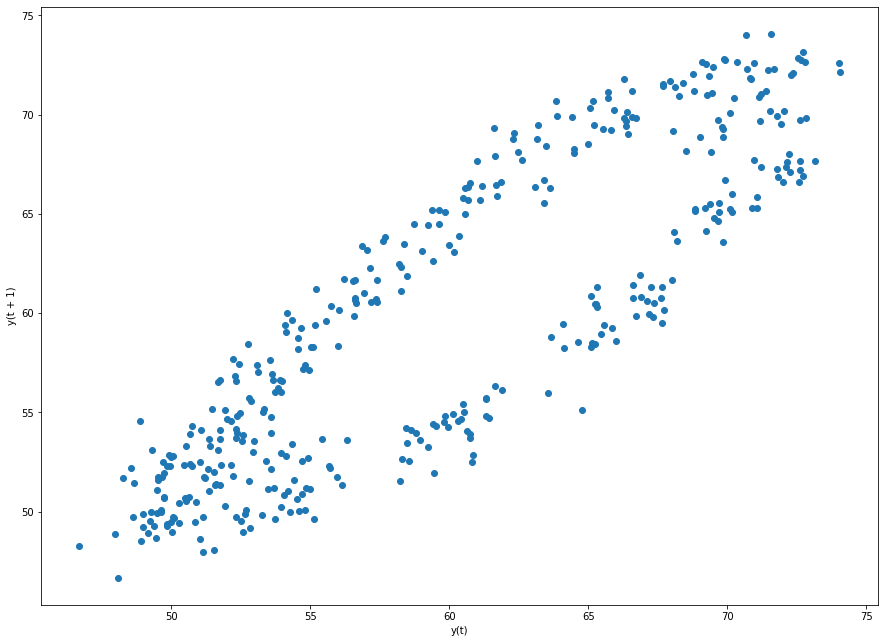

In [32]:
lag_plot(df['TMAX'])

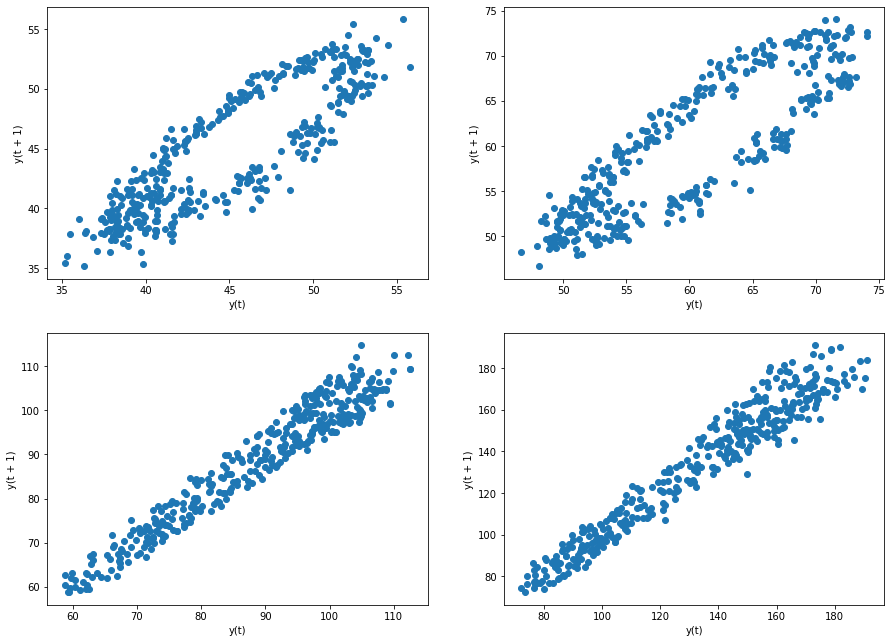

In [48]:
plt.subplot(221)
lag_plot(df['TMIN'])

plt.subplot(222)
lag_plot(df['TMAX'])

plt.subplot(223)
lag_plot(df['ELECTRIC_PROD'])

plt.subplot(224)
lag_plot(df['BEER_PROD'])

plt.show()

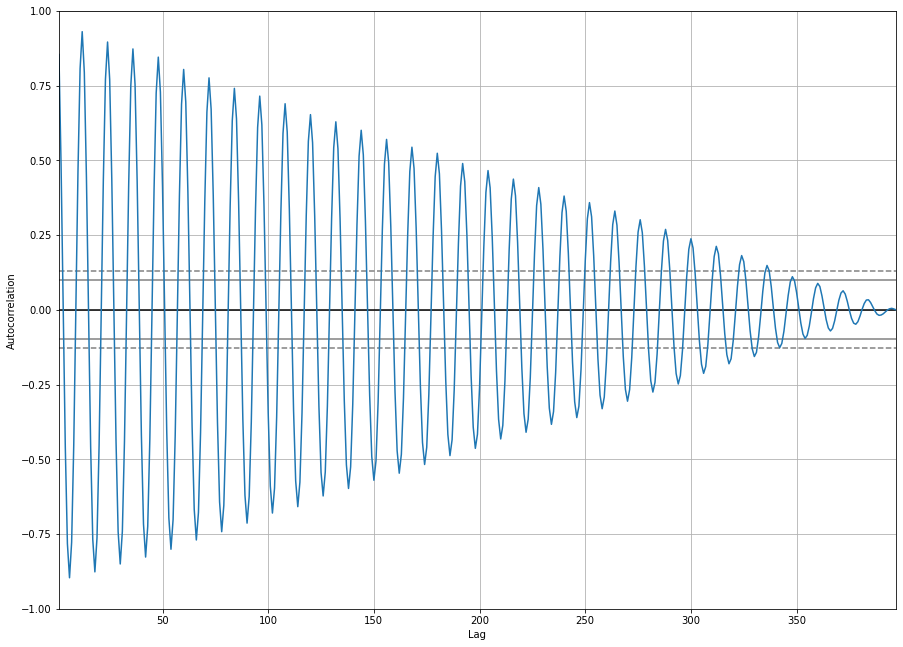

In [62]:
autocorrelation_plot(df['TMAX']);

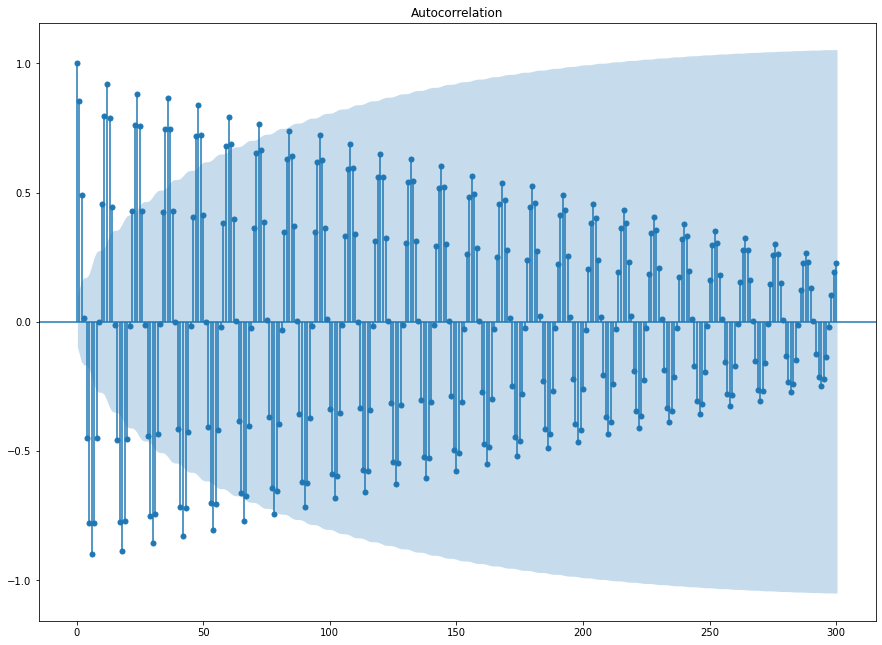

In [64]:
plot_acf(df['TMIN'], lags=300);

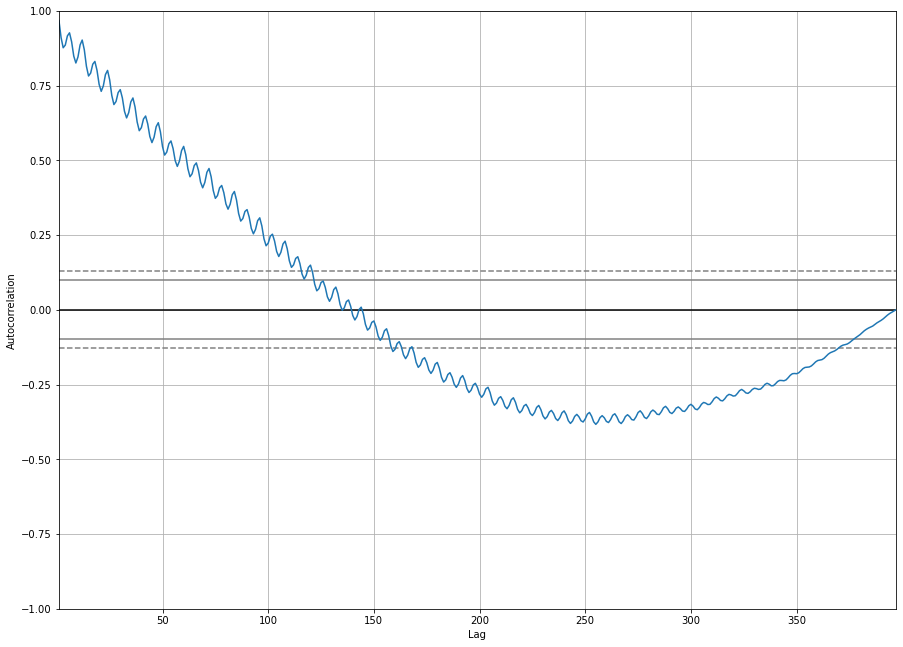

In [68]:
autocorrelation_plot(np.log(df['ELECTRIC_PROD']));

<AxesSubplot:xlabel='DATE'>

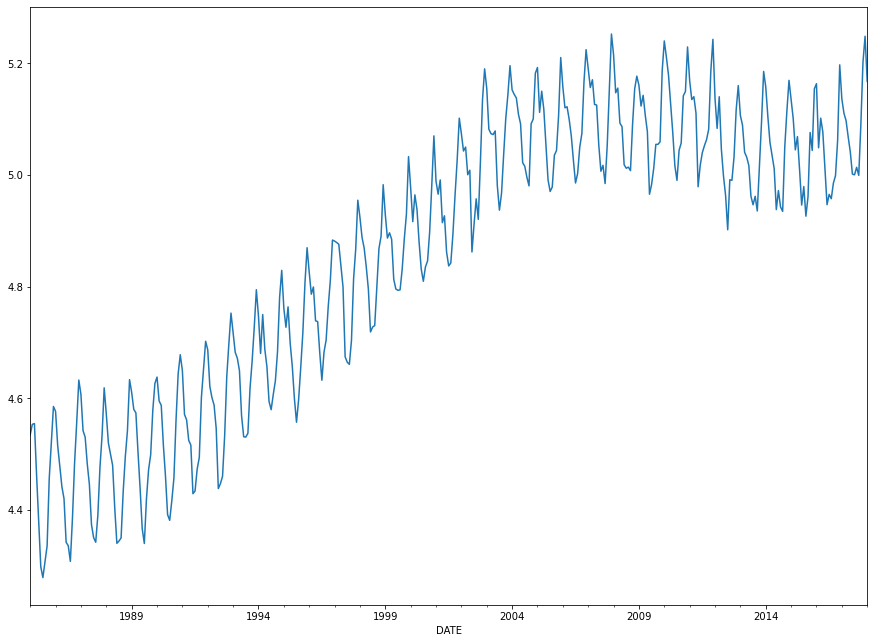

In [75]:
np.log(df['BEER_PROD']).plot()

<AxesSubplot:xlabel='DATE'>

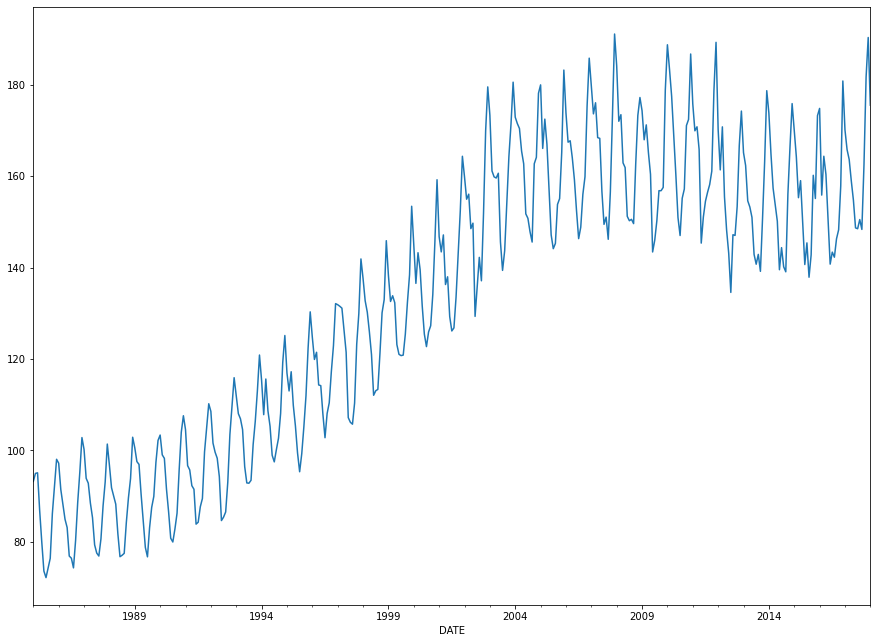

In [76]:
df['BEER_PROD'].plot()